In [15]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

We only focus on maximizing inter-embedding space, but we PAIR the embeddings, so we expect them to group together over time

In [16]:

def plot_embeddings(embs):
    embs_temp = embs.clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.view_init(25, 10)

    # plot embeddings
    for emb in embs_temp:
        ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='blue')

In [17]:
"""
Function that shuffles indexes (duplicates allowed) where at least we know
the new index is NOT the original index!
"""
def shuffled_indices(max_index):
    out = []
    for idx in range(max_index):
        out.append(random.choice([x for x in range(max_index) if not x == idx]))
    return out

shuffled_indices(20)


[13, 17, 5, 9, 7, 2, 4, 17, 16, 13, 19, 10, 6, 10, 1, 7, 8, 13, 11, 11]

In [18]:
def switch_indices(max_index):
    out_idx = []
    orig_idx = range(max_index)
    for idx in orig_idx:
        if idx % 2 == 0: #even
            out_idx.append(idx + 1)
        if idx % 2 == 1: #odd
            out_idx.append(idx - 1)
    return torch.tensor(out_idx)

switch_indices(10)

tensor([1, 0, 3, 2, 5, 4, 7, 6, 9, 8])

In [19]:
def get_neg_indices(max_index):
    out_idx = []
    orig_idx = range(max_index)
    for idx in orig_idx:
        if idx % 2 == 0: #even
            out_idx.append(random.choice([x for x in orig_idx if x not in [idx, idx + 1]]))
        if idx % 2 == 1: #odd
            out_idx.append(random.choice([x for x in orig_idx if x not in [idx, idx - 1]]))
    return torch.tensor(out_idx)

get_neg_indices(10)

tensor([5, 5, 5, 9, 0, 3, 8, 3, 4, 4])

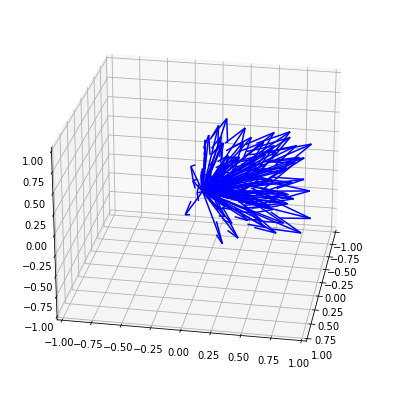

In [20]:
embs = torch.rand((100,3), requires_grad=True)

# show initial random embeddings
plot_embeddings(embs)

-0.3093726634979248
-0.40273839235305786
-0.5305090546607971
-0.5487388372421265
-0.6589646935462952
-0.7526842951774597
-0.7562904357910156
-0.8703575134277344
-0.9202892780303955
-0.9977154731750488
-0.9477803111076355
-0.9907385110855103
-1.0196794271469116
-1.0198609828948975
-0.9640339612960815
-0.9933937788009644
-0.9262142181396484
-1.0477761030197144
-1.0260355472564697
-1.0751827955245972
-1.073527455329895
-0.9983658194541931
-1.0776337385177612
-1.0086371898651123
-0.9525424838066101
-1.0953702926635742
-1.007375717163086
-1.0094127655029297
-1.0045005083084106
-1.082857370376587
-0.9290818572044373
-1.0535712242126465
-1.0776814222335815
-0.957400918006897
-0.9929742813110352
-0.9768458008766174
-0.9977797865867615
-1.0617533922195435
-1.0522998571395874
-0.9923534989356995
-1.0397789478302002
-1.0147733688354492
-1.0390651226043701
-0.9863345623016357
-1.0595855712890625
-1.0136971473693848
-0.9351236820220947
-1.0539597272872925
-0.9666946530342102
-1.0877944231033325


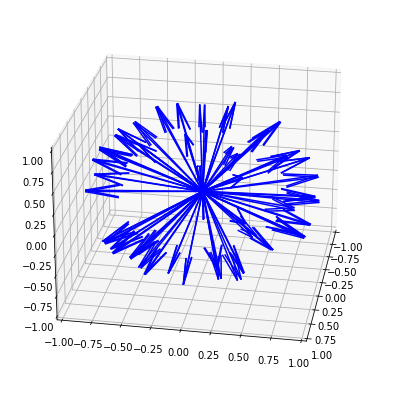

In [26]:
lr=0.1
cos = torch.nn.CosineSimilarity(dim=-1)

# training loop
for step in range(5000):

    # concat the embeddings twice as input
    embs_in = torch.cat((embs, embs), dim=0)

    # get the positive samples
    # switch every 2 indices:   [0,1,2,3,4,5,6,7]
    #                           [1,0,3,2,5,4,7,6]
    embs_switch = switch_indices(embs.size(0))
    pos_in = torch.cat((embs, embs[embs_switch, :]), dim=0)

    # sample negative embeddings that is NOT equal to original index or below odd or above even numbers
    negs_in1 = get_neg_indices(embs.size(0))
    negs_in2 = get_neg_indices(embs.size(0))
    negs_in = embs[torch.cat((negs_in1, negs_in2), dim=0), :]

    loss = torch.mean(cos(embs_in, negs_in)) - torch.mean(cos(embs_in, pos_in))
    if (step+1)%100==0:
        print(loss.item())
    loss.backward()

    # update
    with torch.no_grad():
        embs = embs - embs.grad*lr

    # normalize embeddings each step
    embs = F.normalize(embs)
    embs.requires_grad = True

# plot all embs
plot_embeddings(embs)

I consider this a succesfull test. Embeddings diversify over the embedding space and pair up!

In [27]:
embs

tensor([[ 0.8881, -0.3879, -0.2467],
        [ 0.8915, -0.3747, -0.2544],
        [-0.0465,  0.1249, -0.9911],
        [-0.0396,  0.1166, -0.9924],
        [ 0.8067, -0.4689, -0.3597],
        [ 0.8015, -0.4619, -0.3798],
        [ 0.3831, -0.0806,  0.9202],
        [ 0.3817, -0.0742,  0.9213],
        [ 0.3896, -0.8479,  0.3596],
        [ 0.3871, -0.8525,  0.3512],
        [-0.3169, -0.7964,  0.5151],
        [-0.3156, -0.7981,  0.5132],
        [-0.0864, -0.9098,  0.4060],
        [-0.0879, -0.9116,  0.4015],
        [ 0.1951,  0.1968, -0.9608],
        [ 0.2085,  0.1742, -0.9624],
        [-0.7630,  0.0938,  0.6396],
        [-0.7680,  0.0924,  0.6337],
        [-0.6982, -0.7052,  0.1229],
        [-0.6971, -0.7068,  0.1204],
        [ 0.4874, -0.6793, -0.5485],
        [ 0.4868, -0.6868, -0.5398],
        [-0.3759, -0.8333,  0.4054],
        [-0.3701, -0.8411,  0.3944],
        [-0.1869,  0.8065, -0.5609],
        [-0.1825,  0.8056, -0.5637],
        [ 0.8297,  0.5579,  0.0173],
 